Here I investigate the strategy of training the classifier on randomly selected documents (or perhaps certain active learning strategies that can be considered random), and using it for prediction only after a certain recall threshold has been met. The result is that even for good classifiers with 80% recall, the work saved 

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.stats.proportion import proportion_confint

In [2]:
data = []
for recall in [0.5, 0.7, 0.9, 0.95]:
    for n_relevant_in_sample in range(1, 1000):
        n_predicted = n_relevant_in_sample * recall
        [lower, upper] = proportion_confint(
            n_predicted, n_relevant_in_sample, alpha=0.5, method="wilson"
        )
        data.append([recall, n_relevant_in_sample, recall, lower, upper, upper - lower])
df1 = pd.DataFrame(
    data,
    columns=[
        "recall_group",
        "n_relevant_in_sample",
        "recall",
        "lower",
        "upper",
        "size_of_confint",
    ],
)

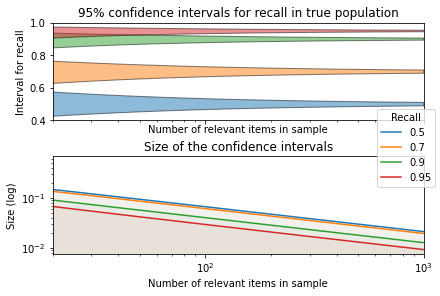

In [10]:
fig, ((ax1), (ax2)) = plt.subplots(2, 1, sharex=True, constrained_layout=True) # type: ignore
for key, group in df1.groupby("recall_group"):
    ax1.fill_between(
        group.n_relevant_in_sample,
        group.lower,
        group.upper,
        alpha=0.5,
        label=key,
        edgecolor="black",
    )
ax1.set_title("95% confidence intervals for recall in true population")
ax1.set_xlabel("Number of relevant items in sample")
ax1.set_ylabel("Interval for recall")
ax1.set_ylim([0.4, 1])
for key, group in df1.groupby("recall_group"):
    ax2.plot(group.n_relevant_in_sample, group.size_of_confint, label=key)
    ax2.fill_between(
        group.n_relevant_in_sample,
        np.zeros(1000-1),
        group.size_of_confint,
        alpha=0.05,
    )
ax2.set_xscale("log")
ax2.set_xlim([20, 1000])
# ax2.set_xticks([20, 50, 100, 200, 500, 1000])
# ax2.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())
ax2.set_xlabel("Number of relevant items in sample")
ax2.set_title("Size of the confidence intervals")
ax2.set_yscale("log")
ax2.set_ylabel("Size (log)")
handles, labels = ax2.get_legend_handles_labels()
fig.legend(handles, labels, title="Recall", loc="right")
plt.show(fig)

In [4]:
data = []
for n_relevant_in_sample in range(0,9):
    # `proportion_confint` is not accurate for this interval
    data.append([n_relevant_in_sample, 1])
for n_relevant_in_sample in range(9, 1000):
    recall_needed = 0
    for recall in np.linspace(1, 0, 10000, endpoint=False):
        n_predicted = n_relevant_in_sample * recall
        [lower, upper] = proportion_confint(
            n_predicted, n_relevant_in_sample, alpha=0.5, method="wilson"
        )
        if lower < 0.95:
            break
        recall_needed = recall
    data.append([n_relevant_in_sample, recall_needed])
df2 = pd.DataFrame(data, columns=["n_relevant_in_sample", "recall_needed"])

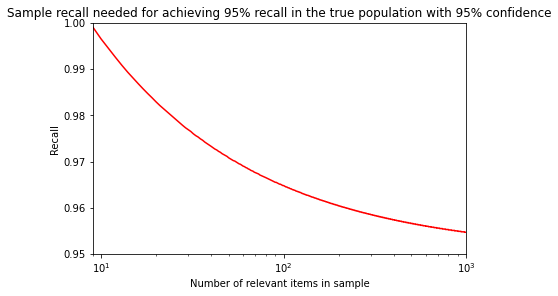

In [5]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(df2.n_relevant_in_sample, df2.recall_needed, color="red")
ax.set_title(
    "Sample recall needed for achieving 95% recall in the true population with 95% confidence"
)
ax.set_xlabel("Number of relevant items in sample")
ax.set_xlim([9,1000])
ax.set_xscale("log")
ax.set_ylabel("Recall")
ax.set_ylim([0.95, 1])
plt.show(fig)

Assume we have 20% relevant documents in our data.

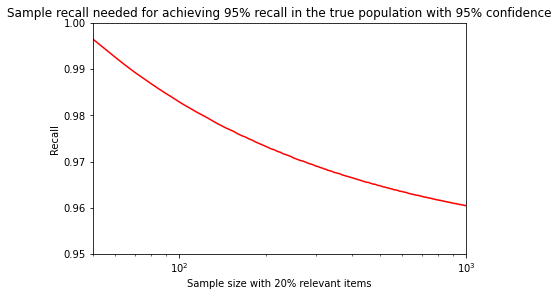

In [6]:
relevant_documents_ratio = 0.2
df2["sample_size"] = df2.n_relevant_in_sample / relevant_documents_ratio
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(df2.sample_size, df2.recall_needed, color="red")
ax.set_title(
    "Sample recall needed for achieving 95% recall in the true population with 95% confidence"
)
ax.set_xlabel("Sample size with 20% relevant items")
ax.set_xlim([50,1000])
ax.set_xscale("log")
ax.set_ylabel("Recall")
ax.set_ylim([0.95, 1])
plt.show(fig)

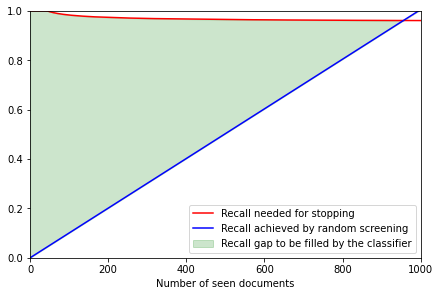

In [30]:
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(df2.sample_size, df2.recall_needed, color="red", label="Recall needed for stopping")
steps = int(1000*relevant_documents_ratio)
recall_via_screening= np.linspace(0,1,steps)
ax.plot(df2.sample_size[:steps], recall_via_screening, color="blue", label="Recall achieved by random screening")
ax.fill_between(
    df2.sample_size[:steps],
    recall_via_screening,
    np.maximum(recall_via_screening, df2.recall_needed[:steps]), 
    color="green",
    alpha=0.2,
    label="Recall gap to be filled by the classifier"
)
ax.set_xlabel("Number of seen documents")
ax.set_xlim([0,1000])
ax.set_ylim([0, 1])
ax.legend()
plt.show(fig)

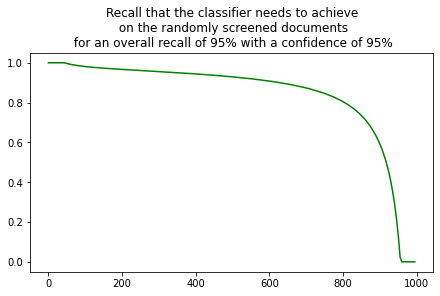

In [12]:
unscreened_docs = np.linspace(1,0,200)
classifier_recall_needed = (unscreened_docs - (1 - df2["recall_needed"][:200])) / unscreened_docs # type: ignore
fig, ax = plt.subplots(constrained_layout=True)
ax.plot(df2.sample_size[:steps], np.maximum(classifier_recall_needed, np.zeros(200)), color="green")
ax.set_title("Recall that the classifier needs to achieve\n on the randomly screened documents\n for an overall recall of 95% with a confidence of 95%")
plt.show(fig)

In [29]:
for x in np.linspace(950/steps, 1000*steps, 500, endpoint=False):
    lower, upper = proportion_confint(x, 1000*steps, alpha=0.5, method="wilson")
    if lower > 0.95:
        print(x)
        break

190080.0
